In [281]:
classname = '食用菌'
goal='批发价格(元/千克)'

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28, 18
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.font_manager as fm

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [283]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_excel("品类数据总表（不含公式）.xlsx")

ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6474 entries, 0 to 6473
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   分类名称        6474 non-null   object        
 1   销售日期        6474 non-null   datetime64[ns]
 2   当日销量        6474 non-null   float64       
 3   当日销售额       6474 non-null   float64       
 4   当日成本价       6474 non-null   float64       
 5   利润率         6474 non-null   float64       
 6   批发价格(元/千克)  6474 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 404.6+ KB


In [284]:
print(ts)

       分类名称       销售日期     当日销量      当日销售额      当日成本价       利润率  批发价格(元/千克)
0       花菜类 2023-06-30   28.087   158.5008  130.10274  0.218274    4.632134
1       花叶类 2023-06-30  130.464  1074.7548  651.58428  0.649449    4.994361
2       辣椒类 2023-06-30   82.286   257.1340  189.63585  0.355936    2.304594
3        茄类 2023-06-30   24.530   320.5760  199.12260  0.609943    8.117513
4       食用菌 2023-06-30   39.572    70.2838   44.78568  0.569336    1.131752
...     ...        ...      ...        ...        ...       ...         ...
6469    花叶类 2020-07-01  205.402   323.3425  222.12993  0.455646    1.081440
6470    辣椒类 2020-07-01   76.715   673.6922  387.39842  0.739016    5.049839
6471     茄类 2020-07-01   35.374   293.7380  180.00814  0.631804    5.088713
6472    食用菌 2020-07-01   35.365   724.4486  472.95274  0.531757   13.373469
6473  水生根茎类 2020-07-01    4.850   512.5522  306.94498  0.669850   63.287625

[6474 rows x 7 columns]


In [285]:
ts.set_index('销售日期', inplace=True)
ts.sort_index(inplace=True)

In [286]:
ts.sort_index(inplace=True)

ts = ts[(ts[goal] > ts[goal].quantile(0.1)) & (ts[goal] < ts[goal].quantile(0.9))]

Energy_sources = ts.groupby('分类名称') #对排放数据进行分组
rcParams['figure.figsize'] = 28, 18


In [287]:
# Energy_sources = ts.groupby('分类名称') #对排放数据进行分组
# rcParams['figure.figsize'] = 28, 18
# fig, ax = plt.subplots()
# for desc, group in Energy_sources:
#     group.plot(y = goal, label = desc,ax = ax,fontsize = 25)
#     ax.set_xlabel(u'时间（月）')
#     ax.set_ylabel(goal)
#     ax.title.set_size(28)
#     ax.xaxis.label.set_size(25)
#     ax.yaxis.label.set_size(25)
#     ax.legend(loc = 'best', fontsize = 18)

In [288]:
# fig, axes = plt.subplots(3,2, figsize = (30, 20))
# for (desc, group), ax in zip(Energy_sources, axes.flatten()):
#     group.plot(y = goal,ax = ax, title = desc, fontsize = 25)
#     ax.set_xlabel('时间')
#     ax.set_ylabel(u'分类名称')
#     ax.xaxis.label.set_size(23)
#     ax.yaxis.label.set_size(23)

In [289]:
ts_grouped = ts.groupby('分类名称')
ts_classname = ts_grouped.get_group(classname)
print(ts_classname)


           分类名称    当日销量     当日销售额      当日成本价       利润率  批发价格(元/千克)
销售日期                                                              
2020-07-01  食用菌  35.365  724.4486  472.95274  0.531757   13.373469
2020-07-02  食用菌  48.510  892.2476  625.13641  0.427285   12.886753
2020-07-03  食用菌  42.442  116.4720   80.24844  0.451393    1.890779
2020-07-04  食用菌  47.262  681.1420  479.78820  0.419672   10.151669
2020-07-05  食用菌  73.213  515.2890  383.55412  0.343458    5.238880
...         ...     ...       ...        ...       ...         ...
2023-06-25  食用菌  35.271  592.5300  391.81200  0.512281   11.108616
2023-06-27  食用菌  38.708  759.9902  408.05555  0.862467   10.541892
2023-06-28  食用菌  53.742  176.8180  144.72835  0.221723    2.693021
2023-06-29  食用菌  48.314  368.6020  229.94141  0.603026    4.759312
2023-06-30  食用菌  39.572   70.2838   44.78568  0.569336    1.131752

[974 rows x 6 columns]


In [290]:
import pandas as pd

mte = ts_classname[goal]
mte = mte.fillna(0)
print(mte)

销售日期
2020-07-01    13.373469
2020-07-02    12.886753
2020-07-03     1.890779
2020-07-04    10.151669
2020-07-05     5.238880
                ...    
2023-06-25    11.108616
2023-06-27    10.541892
2023-06-28     2.693021
2023-06-29     4.759312
2023-06-30     1.131752
Name: 批发价格(元/千克), Length: 974, dtype: float64


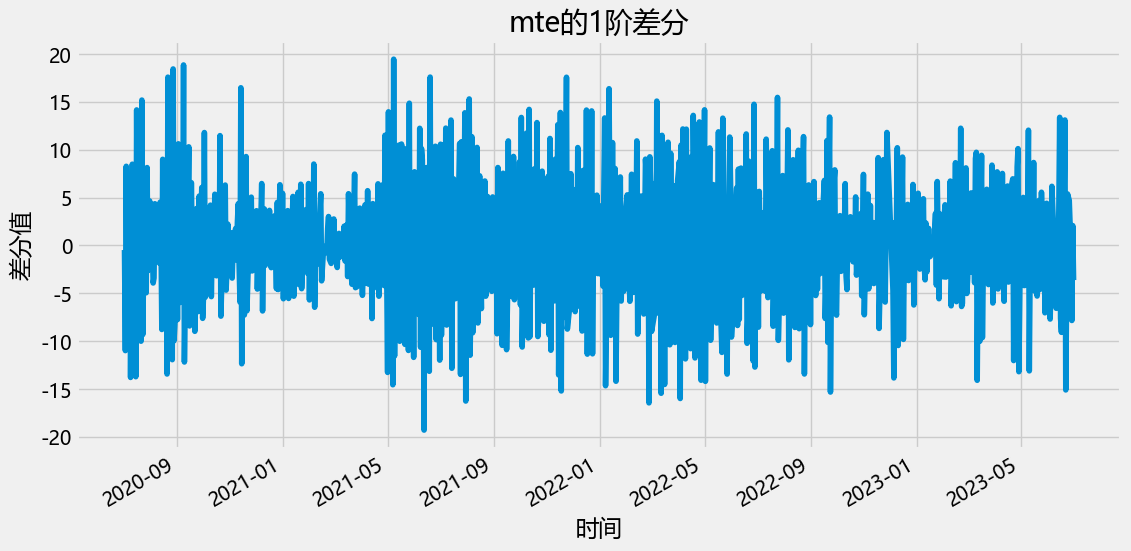

In [291]:
# 对mte作n阶差分，并作图
n = 1  # 阶数
diff_mte = mte.diff(n)
diff_mte.plot(figsize=(12, 6))
plt.xlabel('时间')
plt.ylabel('差分值')
plt.title('mte的{}阶差分'.format(n))
plt.show()

In [292]:
# adfuller单位根检验数据平稳性
from statsmodels.tsa.stattools import adfuller
print(adfuller(mte))  # 原始数据
diff_mte = mte.diff(1)
diff_mte = diff_mte.fillna(0)
print(adfuller(diff_mte))  # 一阶差分



diff_mte = mte.diff(2)
diff_mte = diff_mte.fillna(0)
print(adfuller(diff_mte))  # 二阶差分


(-3.5123330642834665, 0.0076759468952771045, 22, 951, {'1%': -3.4372448882473177, '5%': -2.86458394997689, '10%': -2.5683907715382888}, 5430.473818612123)
(-11.303446954655314, 1.2904956838904833e-20, 20, 953, {'1%': -3.4372303791313144, '5%': -2.864577551835195, '10%': -2.568387363624452}, 5440.881609824835)
(-10.100507945721994, 1.0625845001080854e-17, 21, 952, {'1%': -3.437237626048241, '5%': -2.8645807475403657, '10%': -2.56838906578808}, 5453.993133667267)


In [293]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(mte, lags = 20)

,lb_stat,lb_pvalue
1,13.264556,2.704715e-04
2,15.336045,4.675415e-04
3,77.194434,1.226578e-16
4,78.470120,3.673116e-16
5,127.710337,7.284033e-26
6,350.755828,1.062214e-72
7,350.779129,8.392901e-72
8,354.785547,8.616264e-72
9,382.005900,9.428833e-77
10,386.841863,5.931807e-77


In [294]:
# # 画pacf图和acf图
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# pacf = plot_pacf(diff_mte, lags=40)
# plt.title('PACF')
# pacf.show()
# acf = plot_acf(diff_mte, lags=40)
# plt.title('ACF')
# acf.show()


In [295]:
# import itertools

# # 这里最大最小的参数可以自己调
# p_min = 0
# d_min = 0
# q_min = 0
# p_max = 8
# d_max = 1
# q_max = 8
 
# # Initialize a DataFrame to store the results,，以BIC准则
# results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
#                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
# for p,d,q in itertools.product(range(p_min,p_max+1),
#                                range(d_min,d_max+1),
#                                range(q_min,q_max+1)):
#     if p==0 and d==0 and q==0:
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
#         continue
 
#     try:
#         model = sm.tsa.ARIMA(diff_mte, order=(p, d, q),
#                                #enforce_stationarity=False,
#                                #enforce_invertibility=False,
#                               )
#         results = model.fit()
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
#     except:
#         continue
# results_bic = results_bic[results_bic.columns].astype(float)


In [296]:
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(results_bic,
#                  mask=results_bic.isnull(),
#                  ax=ax,
#                  annot=True,
#                  fmt='.2f',
#                  )
# ax.set_title('BIC')
# plt.show()


In [297]:
# # 这里 max_ 数字越大运行时间越长，这里取8运行时间为 13m 13s
# train_results = sm.tsa.arma_order_select_ic(diff_mte, ic=['aic', 'bic'], trend='c', max_ar=8, max_ma=8)
# print('AIC', train_results.aic_min_order)
# print('BIC', train_results.bic_min_order)

In [298]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA(data, order=(p, d, q))
model = ARIMA(diff_mte, order=(6,2,4))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             批发价格(元/千克)   No. Observations:                  974
Model:                 ARIMA(6, 2, 4)   Log Likelihood               -2809.138
Date:                Sat, 09 Sep 2023   AIC                           5640.277
Time:                        18:14:10   BIC                           5693.950
Sample:                             0   HQIC                          5660.704
                                - 974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8373      0.052    -35.602      0.000      -1.938      -1.736
ar.L2         -1.7422      0.070    -25.023      0.000      -1.879      -1.606
ar.L3         -1.5266      0.078    -19.472      0.000      -1.680      -1.373
ar.L4         -1.3134      0.075    -17.574      0.000      -1.460      -1.167
ar.L5         -1.0602      0.064    -16.448      0.000      -1.187      -0.934
ar.L6         -0.3846      0.038    -10.176      0.000      -0.459      -0.311
ma.L1         -0.0594      0.051     -1.172      0.241      -0.159       0.040
ma.L2         -1.9379      0.047    -40.987      0.000      -2.031      -1.845
ma.L3          0.0592      0.050      1.184      0.237      -0.039       0.157
ma.L4          0.9383      0.047     20.089      0.000       0.847       1.030
sigma2        18.3853      0.845     21.760      0.000      16.729      20.041
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                70.04
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.44
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [299]:
import pandas as pd
import statsmodels.api as sm

# 提取关键信息
summary = result.summary()  # 获取结果的概要信息
params = result.params  # 获取模型参数
resid = result.resid  # 获取残差
fitted_values = result.fittedvalues  # 获取拟合值

# 创建一个 DataFrame
df = pd.DataFrame({
    'Summary': [summary],
    'Parameters': [params],
    'Residuals': [resid],
    'Fitted Values': [fitted_values]
})
import os
if not os.path.exists('arima result'):
    os.makedirs('arima result')
# 将数据存储到 Excel 文件
filename = 'arima result' + '/' + classname +'model'+ '.xlsx'
df.to_excel(filename, index=False)

print("ARIMA 结果已成功保存到 Excel 文件：", filename)

ARIMA 结果已成功保存到 Excel 文件： arima result/食用菌model.xlsx


In [300]:
# # 获取残差
# resid = result.resid

# # 画qq图
# from statsmodels.graphics.api import qqplot
# qqplot(resid, line='q', fit=True)
# plt.show()


In [301]:
from scipy.stats import shapiro
shapiro(resid)

ShapiroResult(statistic=0.9777379631996155, pvalue=4.7044611262148095e-11)

In [302]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

2.002641556155693


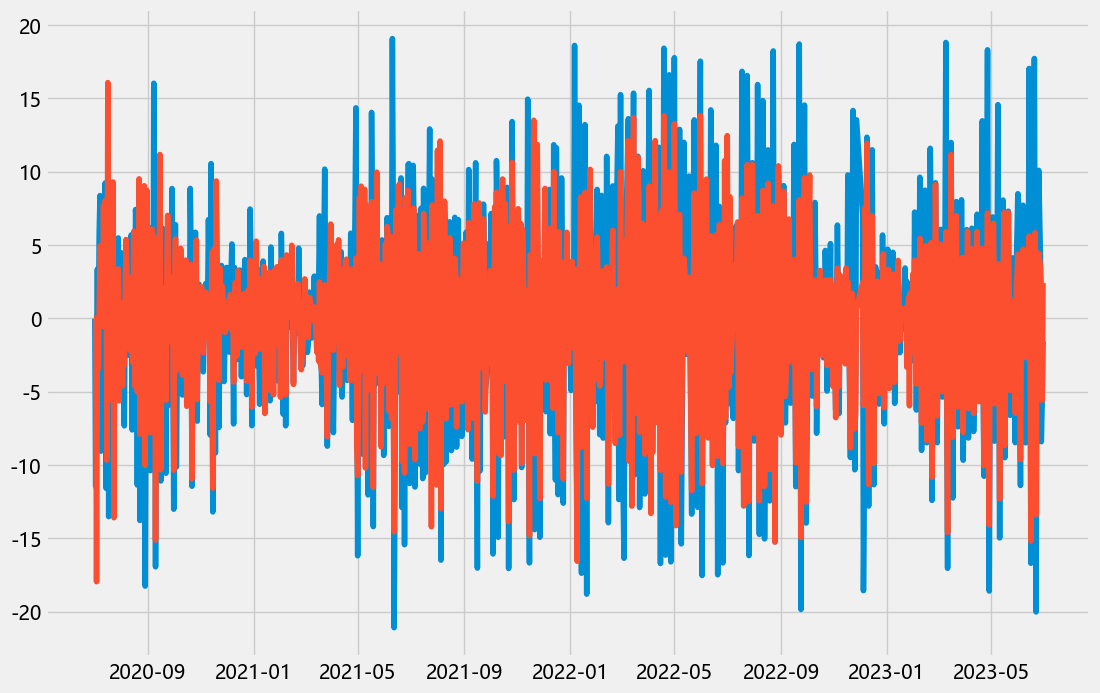

In [303]:
# 预测出来的数据也为一阶差分
# predict(起始时间，终止时间)
predict = result.predict('2020-07-01','2023-06-30')
plt.figure(figsize=(12, 8))
plt.plot(diff_mte)
plt.plot(predict)


In [304]:
# 根据result，使用得到的arima模型预测未来7天的差分值，并且恢复原值
forecast_diff = result.forecast(steps=7)
print(forecast_diff)
forecast = mte.iloc[-1] + forecast_diff.cumsum()
print(forecast)



974    1.130631
975    8.002398
976    0.088760
977   -4.959126
978   -1.411014
979   -0.556519
980    1.472372
Name: predicted_mean, dtype: float64
974     2.262383
975    10.264781
976    10.353540
977     5.394414
978     3.983400
979     3.426881
980     4.899254
Name: predicted_mean, dtype: float64


In [305]:


# Save the result to an xlsx file
import os
if not os.path.exists('arima result'):
    os.makedirs('arima result')
filename = 'arima result' + '/' + classname +'result'+ '.xlsx'
forecast.to_excel(filename, index=False)
print("ARIMA 结果已成功保存到 Excel 文件：", filename)




ARIMA 结果已成功保存到 Excel 文件： arima result/食用菌result.xlsx
